# metrics 

> common metrics for binary and multiclass classification

In [ ]:
#| default_exp metrics

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Union

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#| export
def accuracy_score(y_true: np.ndarray, # true labels 
                   y_pred: np.ndarray, # predicted labels
                   normalize=False, # if weights is not None, normalize by sum of weights
                   sample_weight: Union[np.ndarray,None] = None, # weights for each sample
                   ):
    """computes accuracy for binary or multiclass classification"""
    scores = (y_true==y_pred).astype(float) # bool*int, int*float not allowed
    if sample_weight is not None: scores *= sample_weight 
    scale = sample_weight.sum() if sample_weight is not None else scores.size
    return scores.sum()/scale.astype(float) if normalize else scores.sum()

In [ ]:
from sklearn.metrics import accuracy_score as acc
from fastcore.test import test_eq

In [ ]:
x = np.array([0, 1, 2, 3])
y = np.array([0, 1, 2, 5])
weight = np.array([1, 1, 1, 0])
test_eq(accuracy_score(x,y, normalize=True, sample_weight = weight), acc(x,y, normalize=True, sample_weight=weight))

In [ ]:
#| export
def confusion_matrix(
        y_true: np.ndarray, # true labels
        y_pred: np.ndarray, # predicted labels
        sample_weight: Union[np.ndarray,None] = None, # weights for each sample
):
    """compute confusion matrix for multiclass classification;
    assume all labels are present and range from 0 to n_classes-1;
    $C_{ij}$ is the number of samples that have true label $i$ and predicted label $j$
    
    """
    labels = np.union1d(y_true, y_pred)
    # one hot encode the labels then use matrix multiplication to count things
    ohe_true = np.eye(labels.size)[y_true]
    ohe_pred = np.eye(labels.size)[y_pred] 
    # handle weights
    if sample_weight is not None:
        ohe_true = ohe_true*sample_weight[:,None]
    C = ohe_true.T @ ohe_pred
    return C

In [ ]:
from sklearn.metrics import confusion_matrix as cm

In [ ]:
y_true = np.array([0, 1,2,0])
y_pred = np.array([0, 1,0,0])
weight = np.array([1, 2, 3, 4])
test_eq(confusion_matrix(y_true, y_pred, sample_weight=weight), cm(y_true, y_pred, sample_weight=weight))

In [ ]:
#| export
def precision_recall_fscore(y_true:np.ndarray,# true labels 
                            y_pred:np.ndarray, # predicted labels
                            ):
    labels = np.union1d(y_true, y_pred)
    recs = np.zeros(labels.size)
    pres = np.zeros(labels.size)
    for i, label in enumerate(labels):
        tp = (y_true==label).astype(float) @ (y_pred==label)
        fp = (y_true!=label).astype(float) @ (y_pred==label)
        fn = (y_true==label).astype(float) @ (y_pred!=label)
        recs[i] = tp/(tp+fn)
        pres[i] = tp/(tp+fp)
    fs = 2*recs*pres/(recs+pres)
    return pres.mean(), recs.mean(), fs.mean()

In [ ]:
#| export
def precision_score(y_true, y_pred):
    """compute the average precision, even in the binary case"""
    prec, _, _ = precision_recall_fscore(y_true, y_pred)
    return prec

In [ ]:
#| export
def recall_score(y_true, y_pred):
    """compute the average recall, even in the binary case"""
    _, rec, _ = precision_recall_fscore(y_true, y_pred)
    return rec

In [ ]:
#| export
def f1_score(y_true, y_pred):
    """compute the average f1, even in the binary case"""
    _, _, f1 = precision_recall_fscore(y_true, y_pred)
    return f1

In [ ]:
(
    precision_score(np.array([0, 1, 1,0]), np.array([1,1,0,0])),
    recall_score(np.array([0, 1, 1,0]), np.array([1,1,0,0])),
    f1_score(np.array([0, 1, 1,0]), np.array([1,1,0,0]))
)

(0.5, 0.5, 0.5)

In [ ]:
#| export
def log_loss(y_true, y_pred, *, sample_weights=None):
    """ y_true.dim == 1, y_pred.dim == 2, sample_weights.dim == 1"""
    probs = y_pred[np.arange(y_true.size),y_true]
    if sample_weights is not None: 
        loss = -np.log(probs) @ sample_weights / sample_weights.sum()
    else: 
        loss = -np.log(probs).mean()
    return loss

In [ ]:
log_loss(np.array([0, 1, 1]), np.array([[0.1, 0.9], [0.9, 0.1], [0.1, 0.9]]), sample_weights=np.array([1, 1, 100]))

0.14844335050755605

In [ ]:
#| export
def roc_curve(y_true, y_score, *, pos_label=None):
    y_true = y_true.reshape(-1,1)
    if y_score.ndim == 1:
        y_score = np.concatenate([1-y_score.reshape(-1,1), y_score.reshape(-1,1)], axis=-1)
    y = np.concatenate([y_true, y_score], axis=-1)
    labels = np.sort(np.unique(y_true)) # assume all labels are present in y_true
    tprs = np.zeros(y_score.shape)
    fprs = np.zeros(y_score.shape)
    thresholds = np.zeros(y_score.shape)
    for i in range(len(labels)):
        idxs = np.argsort(y, axis=0)[::-1,i+1] # idxs that sort arr by score descending
        yi = np.where(y[idxs,0]==labels[i], 1, 0) # rewrite y_true to binary
        tcum = np.cumsum(yi)
        tprs[:,i] = tcum/tcum[-1]
        fcum = np.cumsum(1-yi)
        fprs[:,i] = fcum/fcum[-1]
        thresholds[:,i] = y[idxs,i+1]
    if pos_label is None:
        # assume {-1,1} or {0,1} labels in y_true
        pos_label = 1
    idx = np.where(labels==pos_label)[0].item()
    return fprs[:,idx], tprs[:,idx], thresholds[:,idx]

In [ ]:
roc_curve(np.array([0, 1, 1, 0]), np.array([[0.3, 0.7], [0.9, 0.1], [0.1, 0.9], [0.8, 0.2]])) # note: thresthold def is different from sklearn

(array([0. , 0.5, 1. , 1. ]),
 array([0.5, 0.5, 0.5, 1. ]),
 array([0.9, 0.7, 0.2, 0.1]))

In [ ]:
roc_curve(np.array([0, 1, 1, 0]), np.array([0.3, 0.9, 0.1, 0.8]))

(array([0. , 0.5, 1. , 1. ]),
 array([0.5, 0.5, 0.5, 1. ]),
 array([0.9, 0.8, 0.3, 0.1]))

In [ ]:
#| export
def roc_auc_score(y_true, y_score):
    fpr, tpr, _ =  roc_curve(y_true, y_score)
    fpr_inc = (np.roll(fpr,-1) - fpr)[:-1]
    auc = (fpr_inc * tpr[:-1]).sum()
    return auc

In [ ]:
import sklearn.metrics as skm

In [ ]:
a1 = np.array([1,0,1,0,1,1,1,1])
a2 = np.random.random(8)
assert roc_auc_score(a1, a2) == skm.roc_auc_score(a1, a2)

In [ ]:
#| export
class RocCurveDisplay:
    """plot result of `roc_curve` which returns fpr, tpr, _ """
    @classmethod
    def from_predictions(cls, y_true, y_score):
        fpr, tpr, _ = roc_curve(y_true, y_score)
        return plt.plot(fpr, tpr)
    
    @classmethod
    def from_estimator(cls, clf, y_true, y_score):
        raise NotImplemented

[<matplotlib.lines.Line2D>]

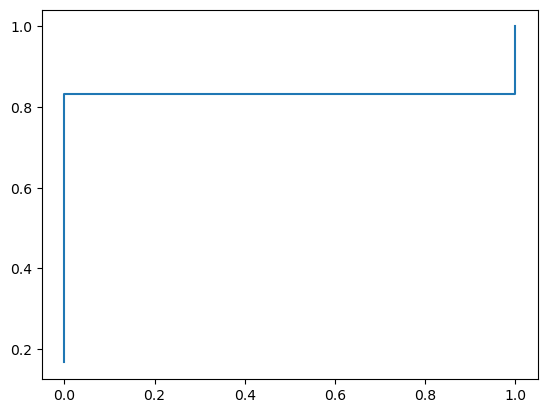

In [ ]:
RocCurveDisplay.from_predictions(a1, a2)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()